## Separating Star Clusters Effectively and Efficiently
### Dario Tringali
### Jeremy Kazimer
### 6/20/21

#### _Import Statements_

In [36]:
import pandas as pds
import numpy as np
import random
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Utility:
import os, sys
sys.path.append('utility/')

from get_data import *

#### _Loading the Data_

Here we create a dataframe from [DEBcat data](https://www.astro.keele.ac.uk/jkt/debcat/debs.dat) and sort it by splitting columns by the space between them.  This creates the `df` variable.  We also remove values earmarked by -9.99, as this means that there is no data for that entry.

In [2]:
debcat_df = get_dataframe(cols_to_remove = ['SpT1', 'SpT2', '[M/H]'])

In [3]:
debcat_df = remove_invalid_values(debcat_df, ['log(Teff1)', 'log(Teff2)', 'log(L1)', 'log(L2)'])

In [4]:
debcat_df.head()

,System,P(d),V,B-V,log(M1),log(M2),log(R1),log(R2),log_g1,log_g2,log(Teff1),log(Teff2),log(L1),log(L2)
0,EPIC_203710387,2.809,14.30,1.80,-0.9363,-0.9763,-0.3648,-0.3730,4.2310,4.2070,3.483,3.483,-1.842,-1.861
2,CM_Dra,1.268,12.90,1.60,-0.6364,-0.6694,-0.5962,-0.6205,4.9940,5.0090,3.496,3.494,-2.258,-2.313
3,UScoCTIO_5,34.001,16.19,1.62,-0.4694,-0.4864,-0.0588,-0.0770,4.0859,4.1053,3.515,3.513,-1.105,-1.146
4,LSPM_J1112+7626,41.033,14.85,1.49,-0.4038,-0.5615,-0.4134,-0.5261,4.8610,4.9290,3.486,3.470,-1.920,-2.210
5,PTFEB_132.707+19.810,6.016,17.89,1.66,-0.4031,-0.6782,-0.4401,-0.5654,4.9150,4.8910,3.513,3.494,-1.863,-2.300


We now want to make a graph using ndf using $ L=A\sigma T^4 $ where L is luminosity, A is the area of the star, $\sigma$ is the Stephan-Boltzmann constant, and T is the temperature. This equation can then be manipulated into a $ y=mx+b $ form: 
$ \log{L}=\log{A\sigma T^4} $ <br> 
$ \log{L}=\log{T^4}+\log{A\sigma } $ <br>
$ \log{L}=4\log{T}+\log{A\sigma } $ <br><br> 
This shows this graph of $\log{L}$ vs. $\log{T}$ should have a slope of $4$.  We can plot this to demonstrate:

In [7]:
log_L = np.append(debcat_df['log(L1)'], debcat_df['log(L2)'])
log_T = np.append(debcat_df['log(Teff1)'], debcat_df['log(Teff2)'])

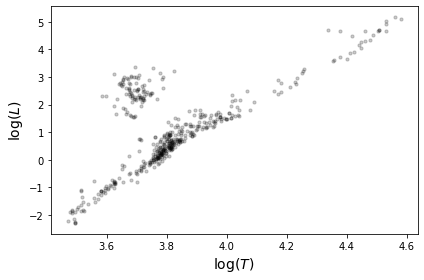

In [63]:
fig, ax = plt.subplots(1, 1)

ax.scatter(log_T, log_L, c = 'black', s = 10, alpha = 1/5)

ax.set_ylabel(r'$\log(L)$', fontsize = 14)
ax.set_xlabel(r'$\log(T)$', fontsize = 14)

fig.tight_layout();

#### _Clustering the Data_

Within this plot we can see a "cloud" of data points that does not follow the linear fit we expect.

We would like to find a way to cluster the data to show what points are apart of the cloud.  From the `sklearn` library we suppose that the Gaussian Mixture model will give us the most accurate cluster, visually speaking.  We would normally anticipate that k-means would fix this data, but the issue stands that it only works one dimensionally.  In order for us to organically rotate it we would need to know the separation, which defeats the purpose of the k-means clustering.

First though, we needed to turn the data we graphed above into an array which we could pass into our algroithm as can be seen below:

In [27]:
debcat_array = np.array((log_T, log_L)).T

In [28]:
debcat_array.shape

(462, 2)

Now we can test the Gaussian Mixture algorithm by defining a function:

In [29]:
def create_model(train, test = None, n_components = 2):
    
    '''
        train -> the data to fit the model on
        test -> the data to train the fitted model.  By default
                we assume the train data to begin with.
        n_components -> the number of clusters.  Based on
                the visual aspect, we anticipate two.
    '''
    
    if test is None:
        test = train
    
    model = GaussianMixture(n_components = n_components)

    model.fit(train)
    
    prediction = model.predict(test)
    
    if n_components == 2:
        prediction = prediction.astype(bool)

    return model, prediction

In [30]:
model, prediction = create_model(debcat_array)

Now, to see what this predicts...

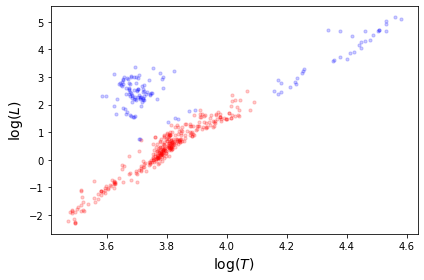

In [32]:
fig, ax = plt.subplots(1, 1)

ax.scatter(log_T[prediction], log_L[prediction], c = 'blue', s = 10, alpha = 1/5)
ax.scatter(log_T[~prediction], log_L[~prediction], c = 'red', s = 10, alpha = 1/5)

ax.set_ylabel(r'$\log(L)$', fontsize = 14)
ax.set_xlabel(r'$\log(T)$', fontsize = 14)

fig.tight_layout();

#### _Fixing the Discontinuities_

Clearly not at all what we predicted.  We hypothesize that this occurs because of the discontinuities from $4.1 \leq \log(T) \leq 4.4$.  So, we can test this by ignoring the data beyond this point.

In [56]:
thresholded_array = debcat_array[debcat_array[:,0] < 4.1]

In [57]:
thresholded_model, new_prediction = create_model(thresholded_array, debcat_array)

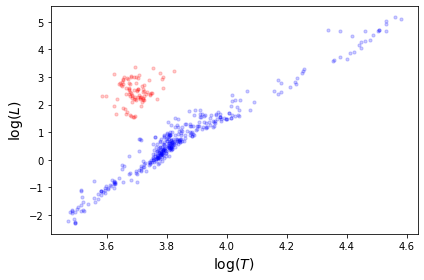

In [58]:
fig, ax = plt.subplots(1, 1)

ax.scatter(log_T[new_prediction], log_L[new_prediction], c = 'blue', s = 10, alpha = 1/5)
ax.scatter(log_T[~new_prediction], log_L[~new_prediction], c = 'red', s = 10, alpha = 1/5)

ax.set_ylabel(r'$\log(L)$', fontsize = 14)
ax.set_xlabel(r'$\log(T)$', fontsize = 14)

fig.tight_layout();

This is much better! The reasonable approach then would be to further validate our original hypothesis by synthesizing data in that range so that there is a more complete picture.  In order to do that, we need to determine which class belongs to which clusters.  Since we know that the slope should be $\approx 4$, we can just use whichever is closest.

In [59]:
m_1, b_1 = np.polyfit(log_T[new_prediction], log_L[new_prediction], 1)
m_2, b_2 = np.polyfit(log_T[~new_prediction], log_L[~new_prediction], 1)

if m_1 >= 4:
    m, b = m_1, b_1
    
elif m_2 >= 4:
    m, b = m_2, b_2
    
else:
    
    res = np.argmin(abs([m_1 - 4, m_4]))
    
    if res == 0:
        m, b = m_1, b_2
    else:
        m, b = m_2, b_2

We can now simulate the data:

In [60]:
f = lambda x, m, b: m*x + b

In [117]:
mean = 0.1
std = 0.001

xs = np.linspace(4.0, 4.4, 100)
syn_f = [f(x, m, b) + random.choice([-1, 1])*abs(random.gauss(mean, std)) for x in xs]

In [118]:
synthetic_array = np.array((xs, syn_f)).T
total_array = np.vstack((debcat_array, synthetic_array))

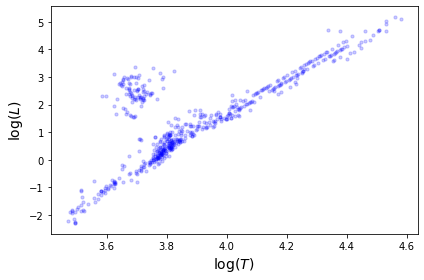

In [119]:
fig, ax = plt.subplots(1, 1)

ax.scatter(total_array[:, 0], total_array[:, 1], c = 'blue', s = 10, alpha = 1/5)

ax.set_ylabel(r'$\log(L)$', fontsize = 14)
ax.set_xlabel(r'$\log(T)$', fontsize = 14)

fig.tight_layout();

So, our data looks good now...but how does it classify?

In [120]:
synthetic_model, synthetic_prediction = create_model(total_array)

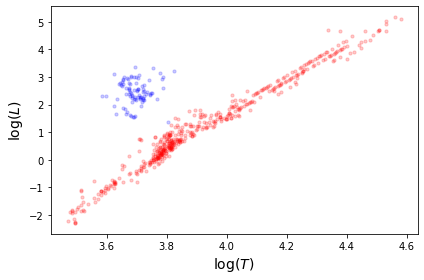

In [121]:
fig, ax = plt.subplots(1, 1)

ax.scatter(total_array[:, 0][synthetic_prediction], 
           total_array[:, 1][synthetic_prediction], c = 'blue', s = 10, alpha = 1/5)

ax.scatter(total_array[:, 0][~synthetic_prediction], 
           total_array[:, 1][~synthetic_prediction], c = 'red', s = 10, alpha = 1/5)

ax.set_ylabel(r'$\log(L)$', fontsize = 14)
ax.set_xlabel(r'$\log(T)$', fontsize = 14)

fig.tight_layout();

#### _Random Sampling Model_

From this, we can see our Gaussian Mixture clustering was indeed successful.  From this, we can conclude that the discontinuities were the issue all along.

The issue with this model, however, is that given any other data in a similar structure, we would not know how to separate this.  We can visually determine $4.1 \leq \log(T) \leq 4.4$, but what happens for different data?

As such, we want to try to create our own algorithm that could take any similar set of points and cluster them properly.  An approach that comes to mind is randomly taking $p$ percentage of points and fitting a model to that set.  Then, we would train all of the points to that set and save the clustering.  For $N$ iterations, we would anticipate that in large $N$ it converges in high accuracy.  

We can construct this model by reusing our existing model:

In [150]:
def create_random_model(data, N, p, n_components = 2, print_progress = False):
    
    '''
        data -> the data that we'll subsample.
        N -> the number of iterations
        p -> the percentage of points to train on.
        n_components -> the number of clusters.
        print_progress -> whether or not to print the percentage complete.
    '''
    
    n_data = data.shape[0]
    indices = np.arange(0, n_data)
    max_points = int(p*n_data)
    
    predictions = np.zeros((data.shape[0]))
    
    for n in range(N):
        
        random_indices = np.random.choice(indices, max_points)
        random_data = data[random_indices]
        
        _, random_prediction = create_model(random_data, data)
        
        predictions += random_prediction
        
        if print_progress == True:
            print('{:.2f}% done!'.format((n + 1)/N)*100)
        
    return np.round(predictions/N).astype(bool)

In [159]:
random_prediction = create_random_model(debcat_array, 500, 0.55)

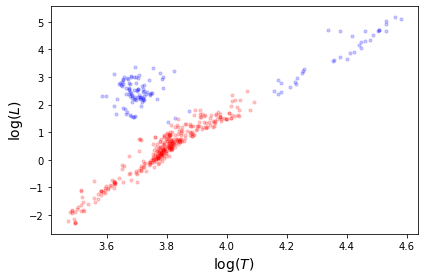

In [160]:
fig, ax = plt.subplots(1, 1)

ax.scatter(log_T[random_prediction], log_L[random_prediction], c = 'blue', s = 10, alpha = 1/5)
ax.scatter(log_T[~random_prediction], log_L[~random_prediction], c = 'red', s = 10, alpha = 1/5)

ax.set_ylabel(r'$\log(L)$', fontsize = 14)
ax.set_xlabel(r'$\log(T)$', fontsize = 14)

fig.tight_layout();

In [ ]:
# WE SHOULD DO RUNTIME ANALYSIS :thinking: